In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score


In [3]:
# 加载已训练的ResNet模型和权重
pretrained_model = models.resnet50()
pretrained_model.fc = torch.nn.Linear(2048, 4)  # 修改全连接层的输出维度为4
model_weights_path = '/Users/tanxinyu/model/model3-2.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.load_state_dict(torch.load(model_weights_path, map_location=device))

pretrained_model.eval()

# 定义图像转换操作
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义分类标签
class_labels = ["Gangrene", "Infection", "Normal","Ulcer", ]


# 初始化存储真实标签和预测标签的列表
true_labels = []
predicted_labels = []
all_probabilities = []

In [6]:
# 遍历测试数据集中的每个类别文件夹
test_data_dir = 'split1/val'
for class_name in class_labels:
    class_dir = os.path.join(test_data_dir, class_name)
    for image_filename in os.listdir(class_dir):
        # Check if the file is a hidden file and skip it
        if image_filename.startswith("."):
            continue
        image_path = os.path.join(class_dir, image_filename)
        image = Image.open(image_path).convert('RGB')
        transformed_image = transform(image).unsqueeze(0)

        # 进行分类预测
        with torch.no_grad():
            outputs = pretrained_model(transformed_image)
            _, predicted = torch.max(outputs, 1)
            predicted_label = class_labels[predicted.item()]

        # 记录真实标签和预测标签
        true_labels.append(class_name)
        predicted_labels.append(predicted_label)

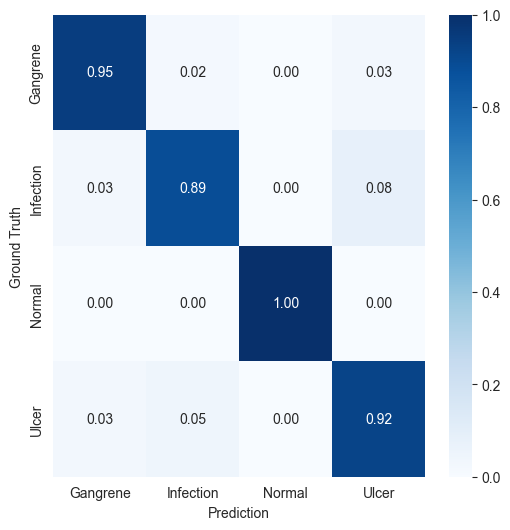

In [7]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 计算混淆矩阵中的比例数
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 绘制混淆矩阵
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

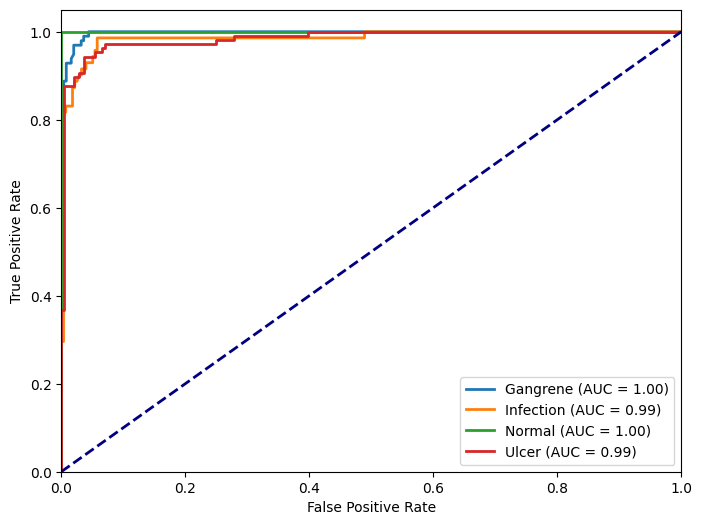

In [4]:
# 遍历测试数据集中的每个类别文件夹
test_data_dir = 'split1/val'
for class_name in class_labels:
    class_dir = os.path.join(test_data_dir, class_name)
    for image_filename in os.listdir(class_dir):
        # Check if the file is a hidden file and skip it
        if image_filename.startswith("."):
            continue

        image_path = os.path.join(class_dir, image_filename)
        image = Image.open(image_path).convert('RGB')
        transformed_image = transform(image).unsqueeze(0)

        # 进行分类预测
        with torch.no_grad():
            outputs = pretrained_model(transformed_image)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
            _, predicted = torch.max(outputs, 1)
            predicted_label = class_labels[predicted.item()]

        # 记录真实标签和预测标签
        true_labels.append(class_name)
        predicted_labels.append(predicted_label)
        all_probabilities.append(probabilities.cpu().numpy())

# Calculate ROC curves for each class
all_probabilities = np.array(all_probabilities)
roc_curves = []

for class_idx, class_name in enumerate(class_labels):
    class_labels_binary = (np.array(true_labels) == class_name).astype(int)
    class_probs = all_probabilities[:, class_idx]
    
    fpr, tpr, _ = roc_curve(class_labels_binary, class_probs)
    roc_auc = auc(fpr, tpr)
    
    roc_curves.append((fpr, tpr, roc_auc, class_name))

# Plot ROC curves
plt.figure(figsize=(8, 6))
for fpr, tpr, roc_auc, class_name in roc_curves:
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('figs/roc2.png',dpi=800)
plt.show()


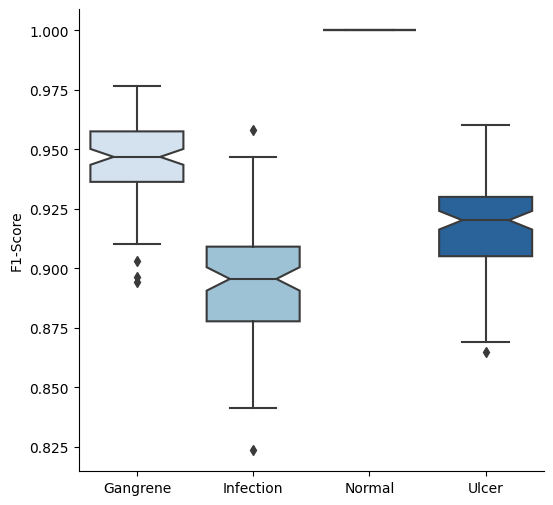

In [7]:
# 初始化存储真实标签和预测概率的列表
true_labels = []
all_probabilities = []

# 遍历验证数据集中的每个类别文件夹
test_data_dir = 'split1/val'
for class_name in class_labels:
    class_dir = os.path.join(test_data_dir, class_name)
    for image_filename in os.listdir(class_dir):
        # Check if the file is a hidden file and skip it
        if image_filename.startswith("."):
            continue
        image_path = os.path.join(class_dir, image_filename)
        image = Image.open(image_path).convert('RGB')
        transformed_image = transform(image).unsqueeze(0)

        # 进行分类预测
        with torch.no_grad():
            outputs = pretrained_model(transformed_image)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

        # 记录真实标签和预测概率
        true_labels.append(class_name)
        all_probabilities.append(probabilities)

# 定义重复抽样的次数
num_iterations = 100

# 存储每次抽样得到的 F1 值
f1_scores = []

for _ in range(num_iterations):
    # 随机选择样本进行抽样，确保每次都有相同的样本
    sampled_indices = np.random.choice(len(true_labels), len(true_labels), replace=True)
    sampled_true_labels = [true_labels[i] for i in sampled_indices]
    sampled_probabilities = [all_probabilities[i] for i in sampled_indices]

    # 计算每个类别的 F1 值
    f1_values = []
    for class_idx, class_name in enumerate(class_labels):
        class_labels_binary = (np.array(sampled_true_labels) == class_name).astype(int)
        class_probs = np.array(sampled_probabilities)[:, class_idx]
        f1 = f1_score(class_labels_binary, (class_probs >= 0.5).astype(int))
        f1_values.append(f1)

    f1_scores.append(f1_values)

# 转换为 NumPy 数组
f1_scores = np.array(f1_scores)

# 绘制箱线图显示 F1 值分布
plt.figure(figsize=(6, 6))
sns.boxplot(data=f1_scores, notch=True, palette='Blues')
plt.xticks(range(len(class_labels)), class_labels)
plt.ylabel('F1-Score')

# 去掉上方和右边的边框
sns.despine()
plt.savefig('figs/f1.png',dpi=800)
plt.show()
